In [4]:
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget

In [6]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()
    
def make_cmplx_sig(iq_data):
    i = np.array(iq_data[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(iq_data[1:: 2])
    q = q.reshape((len(q), 1))
    print(i[:10])
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten

In [1]:
def read_float_by_unpack_delimeter(file_name, data_type, data_num=0, shift=0, separator='\n'):
    # Load test data
    
    #f = open(file_name,'rb')
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    #print(file_size)
    if data_num == 0:
        if data_type == 'float32':
            data_num = int(file_size / 4)
        if data_type == 'int16':
            data_num = int(file_size / 2)

    if data_type == 'float32':
        t = np.float32
    if data_type == 'int16':
        t = np.int16
    
    
    # Open the binary file using a file object
    print("data num")
    print(data_num)
    print(t)
    
    with open(file_name, 'rb') as file:
    # Read the binary data and convert it to a NumPy array
        data = np.fromfile(file, dtype=t, count=data_num, offset=shift, sep=separator)

    #with open(file_name, 'rb') as f:
     #   for line in f.readlines():
            # Each line represents a binary float, strip the newline and unpack
      #      number = struct.unpack('f', line.strip())[0]
       #     data_raw[i] = number
    
    #print("data num ")
    #print(data_num)
    #  102500 is the number of numbers contained in the document, and a floating point number occupies 4 bytes
    #arr = f.read(data_num * 4)
    #data_raw = struct.unpack('f'*data_num, arr)
    
    return data

In [9]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RRC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf
#%%
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [39]:
def save_cmplx_sig(signal, filename, data_type):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

def downscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * (coeff)

In [40]:
file_path = "qpsk_rrc_int16_.bin"
data_type = 'int16'
data_num = 20000
source_samples = read_float_by_unpack_delimeter(file_path, 'int16', data_num, 0, '')


data num
20000
<class 'numpy.int16'>


[[-20157]
 [ -6428]
 [  4447]
 [ -1472]
 [ -7405]
 [ -3832]
 [  7456]
 [ 16486]
 [  8157]
 [ -2469]]


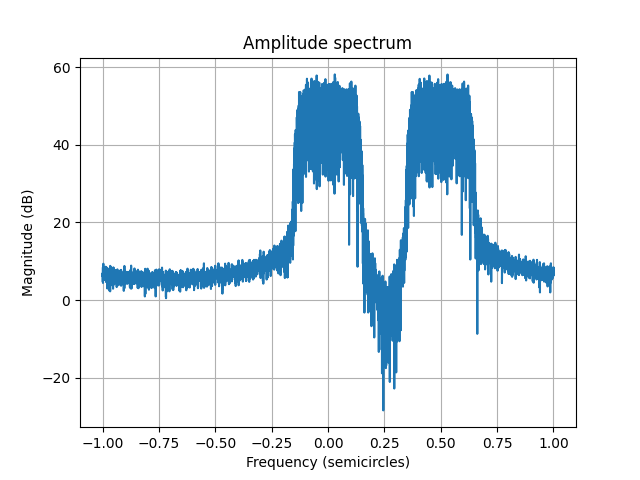

array([[6.26337046],
       [6.92805244],
       [6.79022498],
       ...,
       [8.39292111],
       [6.25984756],
       [8.31015281]])

In [41]:
sig = make_cmplx_sig(source_samples)
plot_spectrum(sig, 0)

In [42]:
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)


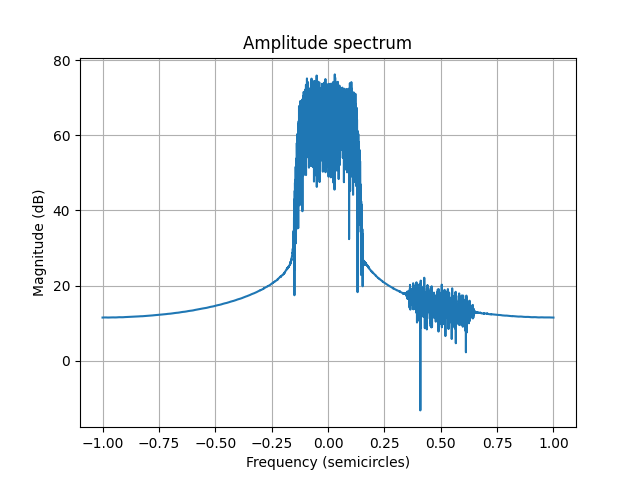

20000
[-35430.516   28647.541  -32061.16    35345.637  -24810.758   41540.863
 -14071.341   47246.36     -839.2372  52356.836   13823.018   56684.97
  28838.545   60372.25    42876.574   63713.27    54688.58    66740.086
  63558.92    69354.54    69220.64    71514.13    71752.164   73043.4
  71687.41    73591.74    69877.76    72787.164   67248.21    70186.52  ]


In [47]:
sig_rrc = np.convolve(sig, s_rrc, 'same')
plot_spectrum(sig_rrc, 1)
save_cmplx_sig(sig_rrc, "qpsk_rrc_int16_after_py_rrc_fl32.bin", 'float32')

In [48]:
sig_rrc_scaled = downscale_to_i16(sig_rrc)
max(sig_rrc_scaled)

(118392.46216280587+67727.91639865939j)
118392.46216280587
116178.38191116066
0.2767659308828368


(32767+18744.779828829913j)

In [44]:
max(sig_rrc)

(118392.46216280587+67727.91639865939j)

In [45]:
max(sig)

(30956-8910j)

In [46]:
max(s_rrc)

1.065577490736439